<a href="https://colab.research.google.com/github/arunabh44/blogs/blob/master/Univariate%20Demand%20Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Demand Forecasting**


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.externals.joblib import dump, load
from datetime import datetime
import os
import statsmodels
import warnings
import itertools
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
try:
  !rm -rf 'model'
except:
  pass

In [3]:
if not os.path.exists("model"):
  os.mkdir('model')

## **Data Preprocessing**

This step includes preprocessing the data for our model

In [4]:
X_test = pd.read_csv("X_test.csv", sep=';')
X_train = pd.read_csv("X_train.csv", sep=';')
Y_test= pd.read_csv("Y_test.csv", sep=';')
Y_train = pd.read_csv("Y_train.csv", sep=';')

In [5]:
X_train.tail()

,key,date,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,...,x73,x74,x75,x76,x77,x78,x79,x80,x81,x82,x83,x84,x85,x86,x87,x88,x89,x90,x91,x92,x93,x94,x95,x96,x97,x98,x99,x100,x101,x102,x103,x104,x105,x106,x107,x108,x109,x110,x111,x112
8432,99444,01Feb2018,0,0,0,0,NaN,NaN,"60,7449855","436,881447","319,4667028","8466,054268","1,407863279","1,120980989","131,4194936","1,134276106","8,349212896","0,570775342","6139,511141",NaN,0,"1,280347961","0,136951372","209,2754088","20,91401309",0,NaN,"6,921252956","315,0869392","7,448178917","10491,60684","10084,37491",0,"2628,252643","31,13086608","6597,251465","231,8008287","96,5269182","68,80412618","0,539560365",...,0,NaN,0,"23,47275949",0,"449,1238676","70,67553956",0,NaN,"14,22882226","72,21757129","2,836828411","0,017392482","-0,039444376",0,"2947,428662","-0,005543801","-1,665191212","0,281968944","5,637226681","3,305562291",0,NaN,"3,636019692","3,659389118","1,082934164","1229,471598","947,0501491","8902,156016",NaN,0,"1733,563294","-28,17433195","1209,449129","632,9662981",0,"110,4228623","-3,137604584","1168,589213","64,49060086"
8433,99444,01Mar2018,0,0,0,0,NaN,"0,22152553","1659,203226","984,5028722","583,7069207","9052,754307","196,4976043","-0,406485569","404,1315231","0,08980729","1,487496214","28,59117839","4923,838551",NaN,"40,84692838","0,477809007","1,036568782","219,8855257","980,4688671",0,"625,2567033","334,7952405","279,792484",0,"37,54251967","107,3441394","1,250577188","31,61530628","2,672018498","112,6905312","13,11522215","76,75774442","136,7584772",0,...,0,NaN,"-0,849185941","760,3554964","16,01731835","67,84054653","109,7171164",0,"0,024969371","3,284838128","213,0996419",0,"12,70221315","36,67095767",0,"3236,812001",0,"0,901150116","0,779730314","39,17103624","0,756281446",0,NaN,"9,32835371","13,6819636","1,056379494","4,51590296","24,5405848","9921,48177",0,"6,430861297","1,393711166",0,"735,3712987","71,4573767","0,131374049","-67,78990443","112,8198698","541,4095713","15,18909821"
8434,99444,01Apr2018,"1,205454964",0,"6,71970436",0,NaN,"5,250907805","391,6299902","835,0517592","1054,700112","7938,10233","75,29421394","135,5396277","961,5332768","12,19432264","214,0998164","95,68327121","6144,648951",NaN,"72,8305803","65,86128374","1,311097093","134,6250215","1,116130064",0,NaN,"1,676845082","48,3412286",0,"91,98388135","26,14645198",0,"0,08401709","0,284635625","114,4073683",0,"32,82005819","32,81249875","1,340341542",...,0,NaN,0,"0,401927269",0,"6910,019035","3531,411917",0,"1027,28725","1,063931485","634,3326161","59,73769791","14,97605123","15,38854703",0,"2187,324868","4,604248892","27,07460222","0,031604615","877,9107075","6,143854835",0,NaN,"24,89026227","176,2962096","0,286754292","44,86245473","5,824296725","8536,513312",NaN,"0,101344605","56,85732759",0,"210,5089961","153,044792","0,433706455","155,9795503","1,532836089","289,1129652","1,863955118"
8435,99444,01May2018,0,0,NaN,0,"141,7708863",NaN,"109,8716506","3388,907606","1349,073196","9805,914396",NaN,"48,63808211","558,4825224","29,37707306","38,09900901","38,04550266","6413,394496",NaN,"2,979598501","4,598354435","0,02820715","268,4738926","572,1255249","0,501858807",NaN,"24,962452","158,5311676","4,947290982","358,9676307","421,3994335",0,"22,26716639","38,5276801","789,7037377","2,834937411","208,7817183","128,7587946","0,407083677",...,0,"95,14092389","182,5588464","50,53072247","-6,322355996","24,28703783","55,50473608",0,NaN,"-0,366575148",0,"-0,259626753","1,484310679","10,97807741",0,"2511,862772",0,"8,578978474",0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"4,368278552","24,96711961","10371,55477",NaN,"0,304818534","8,802166214",0,"78,11681061","17,68775692",0,"-107,2033684","8,136763275","6,391708533","6,154658219"
8436,99444,01Jun2018,0,0,0,0,"10,03366295","600,2648182","284,7281055","4030,602987","298,6389248","8669,324567",NaN,"1,008130969","241,8803596","34,00656244","70,42436912","335,6579931","5693,

In [6]:
'''
Converting date field to datetime format
'''
X_test['date'] = pd.to_datetime(X_test['date'])
X_train['date'] = pd.to_datetime(X_train['date'])
Y_test['date']= pd.to_datetime(Y_test['date'])
Y_train['date'] = pd.to_datetime(Y_train['date'])

In [7]:
'''
Merging the y valye from Ytrain dataset and creating a new dataset
'''
train_data= pd.merge(X_train,Y_train, on = ["key",'date'])
train_data_LSTM = train_data.copy()
train_data =train_data[['key','date','y']]

In [8]:
'''
Changing the strings to integers
'''
for col in train_data.columns:
    if col not in ('key','date'):
        train_data[col]=(train_data[col].str.replace(',','.')).astype('float',errors='ignore')

## Exploratory data analysis

In [9]:
print("Dimension of data: ",train_data.shape)

Dimension of data:  (8437, 3)


In [10]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8437 entries, 0 to 8436
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     8437 non-null   int64         
 1   date    8437 non-null   datetime64[ns]
 2   y       8396 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 263.7 KB


In [11]:
train_data.describe()

,key,y
count,8437.00000,8396.000000
mean,51326.51689,3641.988299
std,29839.15113,2268.977270
min,683.00000,0.000000
25%,20423.00000,1867.329589
50%,57423.00000,3354.446181
75%,77827.00000,5087.705414
max,99444.00000,10000.000000


In [12]:
'''
Maximum and minimum date range 
'''
print(train_data.date.min(),train_data.date.max())

2012-01-01 00:00:00 2018-06-01 00:00:00


In [13]:
'''
Nulls in the data
'''
train_data.isnull().sum()

key      0
date     0
y       41
dtype: int64

In [14]:
'''
Interpolate Sales for missing values
Using previous month's values for 'y' we can use interpolation to fill the missing values in 'y'
'''
train =pd.DataFrame(columns=train_data.columns)
for i in train_data['key'].unique():
  df_key = train_data.loc[train_data['key'] == i]
  df_key['y'] = df_key['y'].interpolate(method ='linear', limit_direction ='backward', limit = 3)
  train =pd.concat([train,df_key],axis=0)


In [15]:

def diff_month(d1, d2):
  ''' 
  Function to find the number of months between two given dates
  '''
  return (d1.year - d2.year) * 12 + d1.month - d2.month

In [18]:
'''
Checking for missing months or any discontinued product(key)
'''
max_train_data = max(train_data['date'])
for i in train_data['key'].unique():
  df_key = train_data.loc[train_data['key'] == i]
  df_key.sort_values("date").reset_index(inplace =True)
  max_date = max(df_key['date'])
  min_date = min(df_key['date'])
  len_data = len(df_key)
  # print(i,len_data)
  m_diff = diff_month(max_date,min_date)
  if len_data != (m_diff+1) and max_date != max_train_data:
    print(i,len_data,m_diff)

In [ ]:
'''
Checking for nulls again
'''
train.isnull().sum()

key     0
date    0
y       0
dtype: int64

Text(0.5, 1.0, 'Annual Sales (Acc.)')

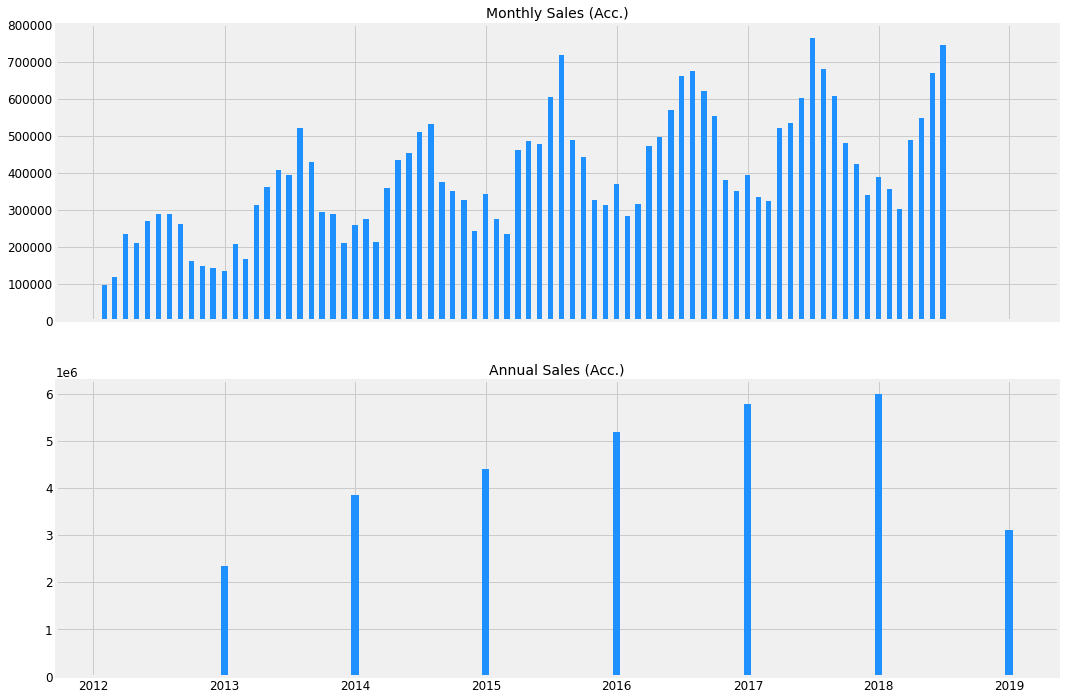

In [ ]:
'''
Plotting Monthly and Yearly Sales for all years for entire range of products
'''
fig, ax = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=(16,12))

resampled_train = train[['date','y']].resample('M', on='date').sum().reset_index(drop=False)
ax[0].bar(resampled_train.date, resampled_train.y, width=15, color='dodgerblue')
ax[0].set_title('Monthly Sales (Acc.)', fontsize=14)

resampled_train = train[['date','y']].resample('Y', on='date').sum().reset_index(drop=False)
ax[1].bar(resampled_train.date, resampled_train.y, width=20, color='dodgerblue')
ax[1].set_title('Annual Sales (Acc.)', fontsize=14)

In [ ]:
'''
Select the key for a product which we want to observe
'''
key = 683

We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise.

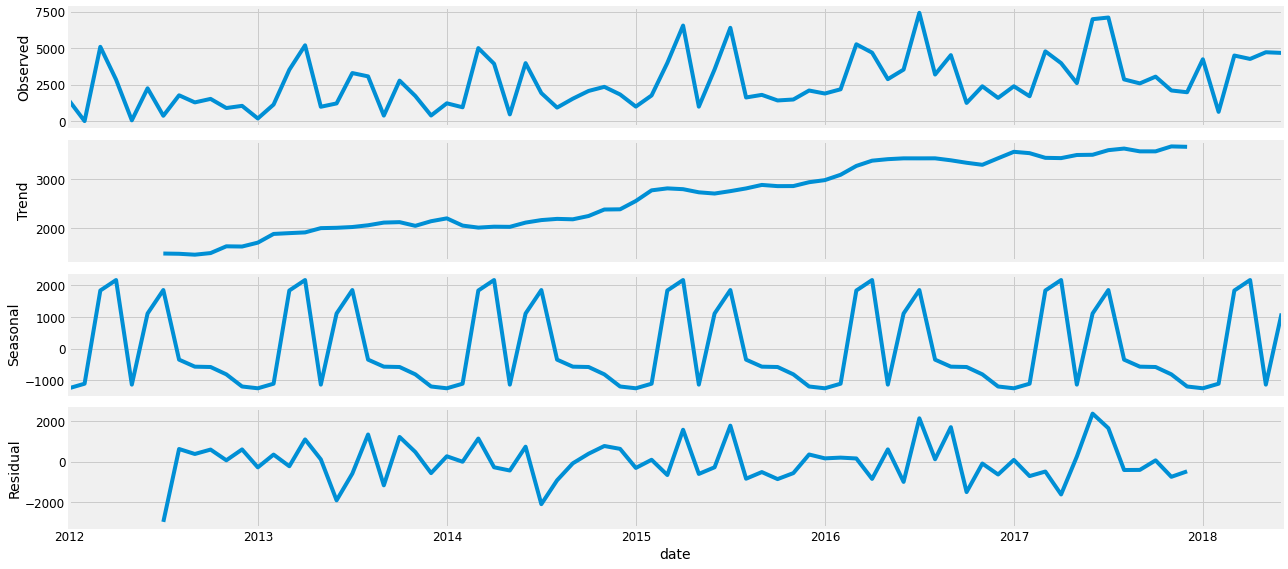

In [ ]:
'''
Plotting Residual,trend,seasonality and Observation for the selected KEY
'''
from pylab import rcParams
y = train.loc[train['key']==key]
y.set_index("date", inplace = True)
y= y[['y']]
y.index.freq = 'MS'
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

## **Time series forecasting with ARIMA**

In [ ]:
df =train.copy()

In [ ]:
'''
Since the data is a time series data, we split the data for each item based on the KEY on a specified split
'''
def _train_test_split(df,split_size=0.8):
  itemList = df['key'].unique()
  df_train = pd.DataFrame()
  df_test = pd.DataFrame()
  for item in itemList:
    df_item = df.loc[df['key'] == item]
    df_item.sort_values("date").reset_index(inplace=True)
    temp_train = df_item.iloc[:int(split_size*len(df_item)),:]
    temp_test = df_item.iloc[int(split_size*len(df_item)):,:]
    df_train = pd.concat([df_train,temp_train])
    df_test = pd.concat([df_test,temp_test])

  return df_train,df_test

In [ ]:
'''
Calling the Splitting function to give us training and testing data witha split of  95:5
'''
df_train,df_test = _train_test_split(df,0.95)

In [ ]:
df_train.nunique()

key      119
date      76
y       7694
dtype: int64

In [ ]:
df_test.nunique()

key     119
date      4
y       448
dtype: int64

In [ ]:
df_train.head()

,key,date,y
0,683,2012-01-01,1430.314968
1,683,2012-02-01,0.000000
2,683,2012-03-01,5088.531900
3,683,2012-04-01,2837.756051
4,683,2012-05-01,51.311689


In [ ]:
df_test.head()

,key,date,y
74,683,2018-03-01,4491.328163
75,683,2018-04-01,4257.036901
76,683,2018-05-01,4716.450361
77,683,2018-06-01,4670.141375
140,894,2018-03-01,3914.871519


This step is parameter Selection for our furniture’s sales ARIMA Time Series Model. Our goal here is to use a “grid search” to find the optimal set of parameters that yields the best performance for our model.

In [ ]:
'''
ARIMA models are denoted with the notation ARIMA(p, d, q). These three parameters account for seasonality, trend, and noise in data
'''
p = d = q = range(0,2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

### NOTE: The model automatically selects the best combination of p,d,q for each **item** after performing Grid Search

In [ ]:
df_pred = pd.DataFrame()
for item in df_train['key'].unique():
  print(item)
  df_key = df_train.loc[df_train['key'] == item]
  df_key.set_index("date", inplace = True)
  dfX = df_key[['y']]
  dfX.index.freq = 'MS'
  lst_params = []
  for param in pdq:
      for param_seasonal in seasonal_pdq:
          try:
              mod = sm.tsa.statespace.SARIMAX(dfX,
                                              order=param,
                                              seasonal_order=param_seasonal,
                                              enforce_stationarity=False,
                                              enforce_invertibility=False)
              
              results = mod.fit()
              lst_params.append([param, param_seasonal, results.aic])
          except:
              continue
  df_params = pd.DataFrame(lst_params,columns=['param','param_seasonal','AIC'])   
  df_params = df_params.sort_values(by=['AIC'], ascending=True)    
  df_params.reset_index(inplace=True)

  '''
  Fitting the ARIMA model
  The model for each product is saved in a folder called model fater training
  ''' 
  mod = sm.tsa.statespace.SARIMAX(dfX,
                                order=df_params['param'][0],
                                seasonal_order=df_params['param_seasonal'][0],
                                enforce_stationarity=False,
                                enforce_invertibility=False)
  results = mod.fit()  
  results.save('model/model_{}.pkl'.format(item))
  

In [ ]:
'''
Validating forecasts
Prediction the test data obtained by 95/5 split and observing the WMAPE values for the model prediction
'''
df_pred = pd.DataFrame()
for item in df_test['key'].unique():
  df_key = df_test.loc[df_test['key'] == item]
  min_date = min(df_key['date'])
  max_date = max(df_key['date'])
  df_key.set_index("date", inplace = True)
  dfX = df_key[['y']]
  dfX.index.freq = 'MS'
  loaded = statsmodels.tsa.statespace.sarimax.SARIMAXResults.load('model/model_{}.pkl'.format(item))
  pred = loaded.get_prediction(start=pd.to_datetime(min_date),end= pd.to_datetime(max_date), dynamic=False)
  y_forecasted = pred.predicted_mean
  df_key['Predicted'] = y_forecasted
  df_pred = pd.concat([df_pred,df_key])

In [ ]:
df_pred

,key,y,Predicted
date,,,
2018-03-01,683,4491.328163,5542.003312
2018-04-01,683,4257.036901,5223.796507
2018-05-01,683,4716.450361,3047.032021
2018-06-01,683,4670.141375,6060.908597
2018-03-01,894,3914.871519,2672.613727
...,...,...,...
2018-06-01,98721,7177.739183,9402.591256
2018-03-01,99444,7854.693921,7398.248327
2018-04-01,99444,4707.540862,6462.993145


In [ ]:
'''
Printing the WMAPE values for each item
'''
for item in df_pred['key'].unique():
  df_key = df_pred.loc[df_pred['key'] == item]
  y_truth = df_key['y']
  y_forecasted = df_key['Predicted']
  WMAPE = ((abs(y_truth-y_forecasted)).sum()/(abs(y_truth)).sum())*100
  print('WMAPE {} : {}'.format(item,round(WMAPE, 2)))

WMAPE 683 : 28.0
WMAPE 894 : 36.18
WMAPE 2831 : 20.22
WMAPE 2835 : 8.47
WMAPE 4361 : 10.43
WMAPE 6846 : 6.22
WMAPE 8200 : 15.35
WMAPE 8284 : 15.65
WMAPE 8507 : 38.97
WMAPE 8992 : 16.76
WMAPE 9822 : 52.29
WMAPE 9902 : 22.03
WMAPE 10638 : 200.1
WMAPE 10873 : 9.03
WMAPE 11438 : 18.63
WMAPE 12429 : 16.38
WMAPE 12851 : 18.46
WMAPE 13142 : 10.35
WMAPE 14208 : 27.25
WMAPE 15684 : 13.45
WMAPE 16071 : 28.27
WMAPE 16288 : 13.14
WMAPE 16764 : 13.29
WMAPE 18726 : 98.35
WMAPE 18769 : 61.27
WMAPE 19961 : 23.69
WMAPE 19983 : 48.37
WMAPE 20118 : 38.89
WMAPE 20423 : 62.13
WMAPE 22658 : 26.51
WMAPE 23001 : 44.72
WMAPE 23155 : 22.85
WMAPE 23620 : 30.55
WMAPE 24248 : 599.84
WMAPE 24488 : 28.93
WMAPE 25608 : 56.84
WMAPE 26405 : 17.41
WMAPE 30503 : 57.93
WMAPE 31088 : 64.83
WMAPE 32360 : 43.89
WMAPE 32462 : 52.39
WMAPE 32473 : 16.44
WMAPE 36516 : 27.3
WMAPE 37081 : 13.2
WMAPE 39686 : 29.84
WMAPE 39943 : 16.46
WMAPE 40698 : 15.48
WMAPE 42401 : 48.77
WMAPE 43045 : 34.1
WMAPE 44612 : 37.66
WMAPE 44732 : 9.9
WM

#Predicting for test data


In [ ]:
X_test.head()

,key,date,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,...,x73,x74,x75,x76,x77,x78,x79,x80,x81,x82,x83,x84,x85,x86,x87,x88,x89,x90,x91,x92,x93,x94,x95,x96,x97,x98,x99,x100,x101,x102,x103,x104,x105,x106,x107,x108,x109,x110,x111,x112
0,683,2018-07-01,0,0,"0,397237973",0,NaN,NaN,"119,9361839","114,0636304","183,4795247","7599,854339","69,61916457","0,462339938","70,0169696","6,499243202","2080,584709","629,6106349","798,0693722",NaN,"19,78606239","5918,616119","35,90201212","25,07984932","218,8955556","0,43357017",NaN,"49,77105427","141,5410936","3,972149052","1,717962697","0,249812987",0,0,0,"1,386167576",0,0,0,0,...,0,"1,59357406",0,"13,75643894","0,147464641","2,237439004","1,096744361",0,NaN,"0,066561682","2,138002147","0,125859877","70,30404126","55,8576785","0,671500867","5976,264094","32,61868547","2,862218851",0,"27,0132962","30,59086268",0,"0,318068778","0,014292318","25,249954",0,"1,416416119","7,701949675","7279,604101","1,016117236","0,019899809","1,064945438",0,"11762,88868","544,3210427",0,"39,59976208","7,289596889","2895,006107","48,66635718"
1,683,2018-08-01,NaN,0,0,0,"74,83278688",NaN,"593,8030916",NaN,NaN,"7129,983016",NaN,NaN,NaN,NaN,"95,95491445","14,39014132","961,3572866",NaN,"33,49412927","20,04825568","1,727713236","40,37962715","278,5685916",0,"379,8243585",0,"26,39192767","1,084692392","14,51414257","3,707841639","0,026478464",NaN,"2,122955024","11,93420266","0,0389237","574,5253156","42,99596953",0,...,NaN,NaN,NaN,NaN,NaN,"472,740312","183,8517843",0,"95,11578117","-2,336392352","348,154269","0,735302933","9410,310945","6905,818827",0,"5683,598011","4,091134977","5081,726973","11,10771727","10,26859187","44,96055882","0,529350852",0,"42,36798848","13,28123681","0,255420395","-1,709794194","12,81846797","3777,535755","0,948180787",0,"-4,437490656","0,141845854","130,0274548","84,1344544","0,357027477","33,09805504","17,2442097","97,63377726","3,189300862"
2,683,2018-09-01,0,0,0,0,NaN,NaN,"222,1067149","7,926073664","2,365508944","3678,029954",NaN,"1,158071699","4,069819807",0,"525,0929097","67,25277742","841,6561463","224,1617023","1,246149529","76,99575012","3,896790305","32,56069878","146,7225358","0,154986315",NaN,"56,26656718","96,69895137","1,333487352","3,499335205","5,630861626",0,"0,008675521","0,235928468","4,930271732","0,537283835","1,745144519","10,27529216","0,268869011",...,"0,313264321",NaN,"103,6502337","33,81253977","0,046913553",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"4373,432383","4030,26706",0,"2838,761331","25,63140732","5241,584063","84,52943105","3033,674639","2765,063946",0,NaN,"14,81828991","2654,609326","32,54147258","80,41918032","37,49314998","5355,291239","53,16945184","127,3785751","42,87911437","1,003184361",NaN,NaN,NaN,"8,638552738",NaN,NaN,NaN
3,683,2018-10-01,"1,532104036","0,576041049",0,0,"52,54041673","21,89077273","59,58862988","361,8708945","20,19773914","5274,149878","33,4573765","2,838253763","54,86781335","2,142438235","286,3768075","340,9970265","922,2344896","108,3566642","55,41786654","666,8338709",0,"44,60591288","176,3005917",0,NaN,"2,342704851","36,28170029",0,"0,364561919","3,608975108",0,NaN,0,"2,95766991",0,"58,61114324","77,08726238",0,...,"0,815112143","13,30235674","162,2606399","294,477142",0,"2,617004978","1,499882699",0,NaN,"0,058861091","1,038144691","0,026917866","264,3660026","7,481647527","0,31148604","4253,539961","2,579106908","295,3566689","10,52474745","1274,979043","366,9861978",0,NaN,"305,1776918","707,7457362","22,5720988","1432,096995","849,1380917","4923,854158",NaN,"6,852296722","196,7480882","43,91936054","102,7356866","2,731286037",0,"14,64671766","2,719439245","48,86695741","0,267833097"
4,683,2018-11-01,0,0,0,"2,412814033","19,0212385","42,03233338","1970,406869","6,444103966","4,975535873","4552,412721",NaN,"0,102330627","0,759609622",0,"20625,35122","7100,112077","1105,512624","3229,309195","1302,158618","7848,897467","10,46662118","256,09822

In [ ]:
test_data = X_test[['key','date']]

In [ ]:
#Prediction on Test data
df_pred_test = pd.DataFrame()
for item in test_data['key'].unique():
  df_key = test_data.loc[test_data['key'] == item]
  min_date = min(df_key['date'])
  max_date = max(df_key['date'])
  df_key.set_index("date", inplace = True)
  loaded = statsmodels.tsa.statespace.sarimax.SARIMAXResults.load('model/model_{}.pkl'.format(item))
  pred = loaded.get_prediction(start=pd.to_datetime(min_date),end= pd.to_datetime(max_date), dynamic=False)
  y_forecasted_test = pred.predicted_mean
  df_key['Predicted'] = y_forecasted_test
  df_pred_test = pd.concat([df_pred_test,df_key])

In [ ]:
df_pred_test.head()

,key,Predicted
date,,
2018-07-01,683,7340.799627
2018-08-01,683,3436.766924
2018-09-01,683,3598.231683
2018-10-01,683,3078.094686
2018-11-01,683,2844.739577


In [ ]:
df_pred_test.to_csv("Prediction.csv")

Some useful graphs and observations

We should always run model diagnostics to investigate any unusual behavior.

In [ ]:
key = 683

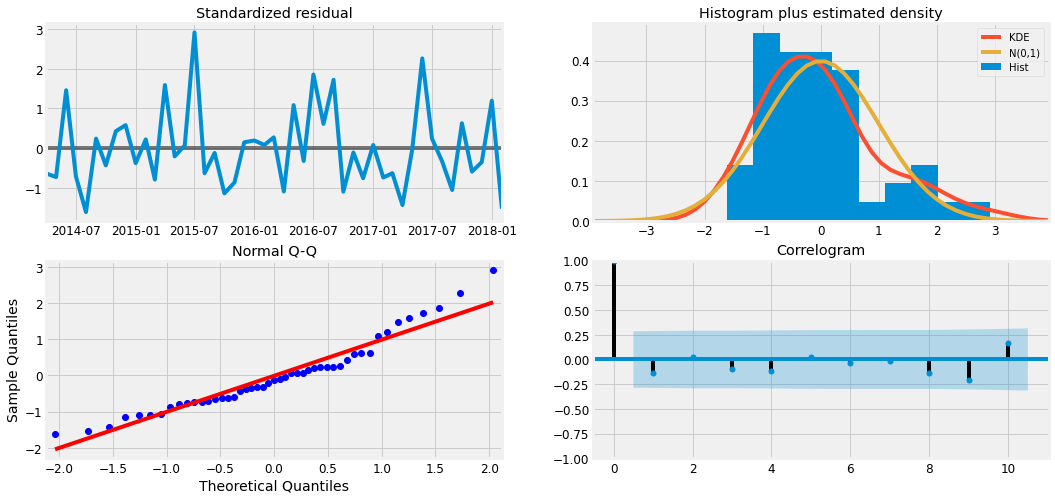

In [ ]:
loaded = statsmodels.tsa.statespace.sarimax.SARIMAXResults.load('model/model_{}.pkl'.format(key)) #Load the KEY which you want to observe
loaded.plot_diagnostics(figsize=(16, 8))
plt.show()